### Import Library

In [5]:
import tensorflow as tf #type : ignore
from tensorflow.keras import layers # type: ignore 
 
from keras.preprocessing.image import ImageDataGenerator #type : ignore

import os
import shutil
import numpy as np #type : ignore

### Create train and test data folder, oversample the data, and split the data into train and test data

In [6]:
import random

def is_image_file(filename):
    """
    Check if a file is an image based on its extension.
    
    Args:
        filename (str): The name of the file.
        
    Returns:
        bool: True if the file is an image, False otherwise.
    """
    image_extensions = {'.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff'}
    return os.path.splitext(filename)[1].lower() in image_extensions

# Path to the original dataset directory
dataset_dir = r'D:/MSIB BANGKIT (6) 2024/Capstone/C_Project/Hiking_Dataset'

# Paths to the new train and test directories
train_dir = r'D:/MSIB BANGKIT (6) 2024/Capstone/C_Project/HikingDatasetTrain'
test_dir = r'D:/MSIB BANGKIT (6) 2024/Capstone/C_Project/HikingDatasetTest'

# Create the new train and test directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Iterate through each folder in the dataset directory
for folder in os.listdir(dataset_dir):
    folder_path = os.path.join(dataset_dir, folder)
    
    if not os.path.isdir(folder_path) or folder == ".DS_Store":
        continue

    # Paths for the corresponding train and test subdirectories
    train_subdir = os.path.join(train_dir, folder)
    test_subdir = os.path.join(test_dir, folder)

    # Create the train and test subdirectories
    os.makedirs(train_subdir, exist_ok=True)
    os.makedirs(test_subdir, exist_ok=True)

    # Get all image files in the folder
    image_files = [f for f in os.listdir(folder_path) if is_image_file(f)]

    # Shuffle the files to ensure random splitting
    random.shuffle(image_files)

    # Calculate split index
    split_index = int(len(image_files) * 0.8)

    # Split the files into train and test sets
    train_files = image_files[:split_index]
    test_files = image_files[split_index:]

    # Copy files to the train and test directories
    for file in train_files:
        src_file = os.path.join(folder_path, file)
        train_file = os.path.join(train_subdir, file)
        try:
            shutil.copy2(src_file, train_file)
        except Exception as e:
            pass  # Handle exceptions as needed

    for file in test_files:
        src_file = os.path.join(folder_path, file)
        test_file = os.path.join(test_subdir, file)
        try:
            shutil.copy2(src_file, test_file)
        except Exception as e:
            pass  # Handle exceptions as needed

### Rescale the image

In [7]:
img_height = 224
img_width = 224
batch_size = 32

### Define class

In [8]:
classes = os.listdir(train_dir)
classes = [c for c in classes if c != ".DS_Store"]
classes

['air mineral',
 'jaket gunung',
 'jas hujan',
 'kompor portable',
 'lampu senter',
 'sarung tangan gunung',
 'sepatu gunung',
 'sleeping bag',
 'tas gunung',
 'tenda',
 'tikar',
 'topi gunung']

### Data Augmentation

In [9]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.5, 1.5),
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Create a Keras DataGenerator with data augmentation
train_ds = datagen.flow_from_directory(
    train_dir,
    subset="training",
    seed=123,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    classes=classes
)

val_ds = datagen.flow_from_directory(
    train_dir,
    subset="validation",
    seed=123,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    classes=classes
)

Found 8074 images belonging to 12 classes.
Found 2013 images belonging to 12 classes.


In [10]:
test_datagen = ImageDataGenerator(
)

test_ds = datagen.flow_from_directory(
    test_dir, 
    seed=123,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    classes=classes

)

Found 3792 images belonging to 12 classes.


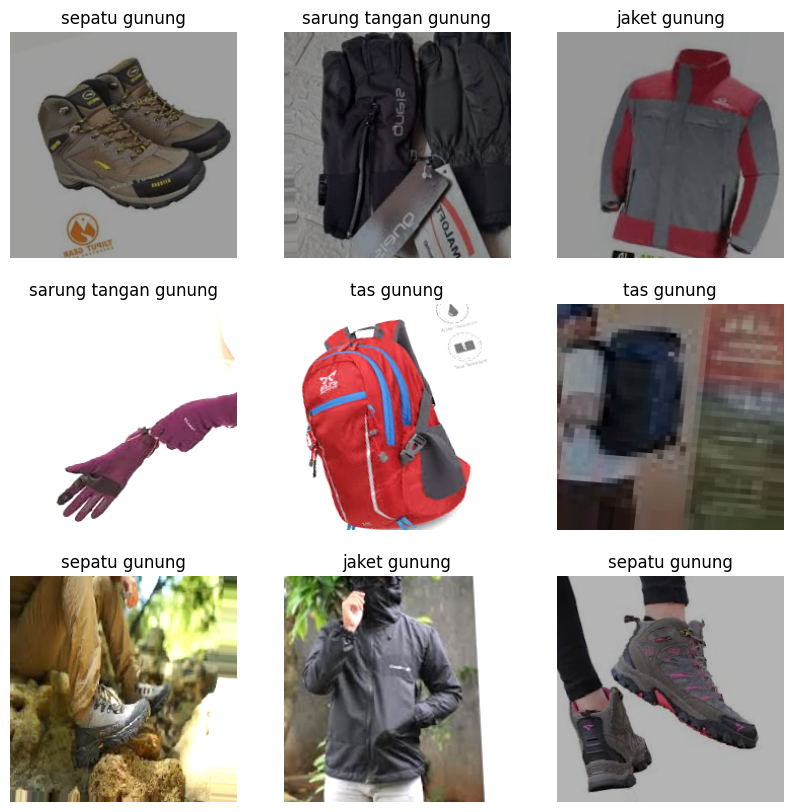

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].astype("uint8"))
        plt.title(classes[int(labels[i])])
        plt.axis("off")
    break

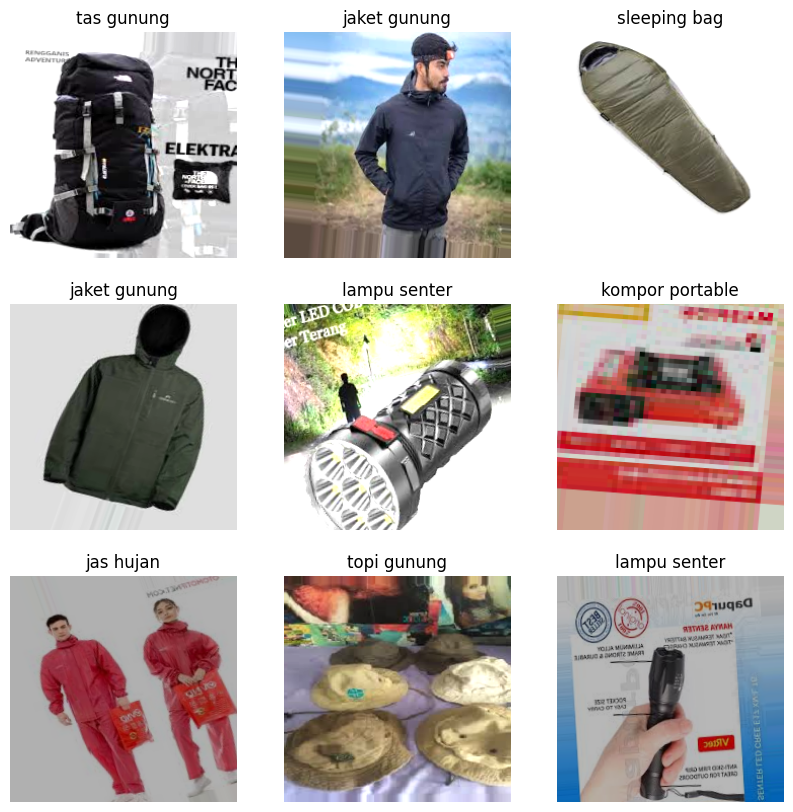

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in test_ds:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].astype("uint8"))
        plt.title(classes[int(labels[i])])
        plt.axis("off")
    break

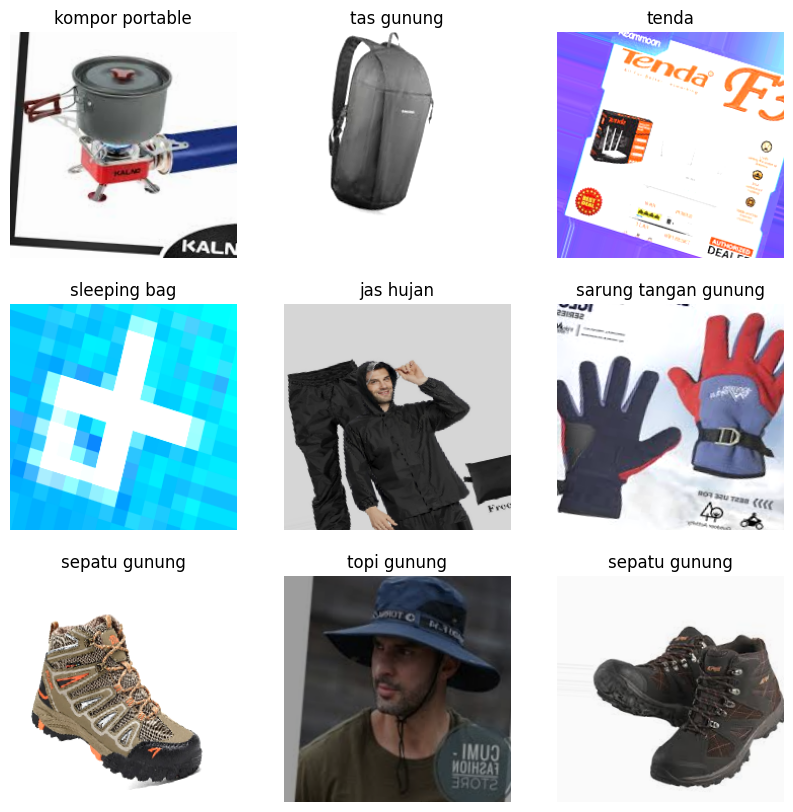

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in val_ds:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].astype("uint8"))
        plt.title(classes[int(labels[i])])
        plt.axis("off")
    break

### Model Building and Architecture Using ResNet50


In [14]:
resnet = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling='avg'
)
out = tf.keras.layers.Dense(len(classes))(resnet.output)
model = tf.keras.models.Model(inputs=resnet.input, outputs=out)

model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                                                                                        

### Training Model

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

EPOCHS = 10
checkpoint_filepath = 'models/resnet50'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[model_checkpoint_callback])


Epoch 1/10


253/253 [==============================] - ETA: 0s - loss: 1.4413 - accuracy: 0.5526INFO:tensorflow:Assets written to: models\resnet50\assets


INFO:tensorflow:Assets written to: models\resnet50\assets


253/253 [==============================] - 1203s 5s/step - loss: 1.4413 - accuracy: 0.5526 - val_loss: 2.9650 - val_accuracy: 0.4337
Epoch 2/10
253/253 [==============================] - 1008s 4s/step - loss: 0.9032 - accuracy: 0.7187 - val_loss: 3.4821 - val_accuracy: 0.4083
Epoch 3/10
253/253 [==============================] - ETA: 0s - loss: 0.7296 - accuracy: 0.7706INFO:tensorflow:Assets written to: models\resnet50\assets


INFO:tensorflow:Assets written to: models\resnet50\assets


253/253 [==============================] - 1044s 4s/step - loss: 0.7296 - accuracy: 0.7706 - val_loss: 1.4958 - val_accuracy: 0.5882
Epoch 4/10
253/253 [==============================] - ETA: 0s - loss: 0.6733 - accuracy: 0.7916INFO:tensorflow:Assets written to: models\resnet50\assets


INFO:tensorflow:Assets written to: models\resnet50\assets


253/253 [==============================] - 948s 4s/step - loss: 0.6733 - accuracy: 0.7916 - val_loss: 1.4906 - val_accuracy: 0.5897
Epoch 5/10
253/253 [==============================] - ETA: 0s - loss: 0.5920 - accuracy: 0.8130INFO:tensorflow:Assets written to: models\resnet50\assets


INFO:tensorflow:Assets written to: models\resnet50\assets


253/253 [==============================] - 887s 4s/step - loss: 0.5920 - accuracy: 0.8130 - val_loss: 0.8701 - val_accuracy: 0.7442
Epoch 6/10
253/253 [==============================] - 907s 4s/step - loss: 0.5653 - accuracy: 0.8238 - val_loss: 0.9493 - val_accuracy: 0.7009
Epoch 7/10
253/253 [==============================] - 886s 4s/step - loss: 0.5198 - accuracy: 0.8397 - val_loss: 0.9272 - val_accuracy: 0.7372
Epoch 8/10
253/253 [==============================] - 878s 3s/step - loss: 0.4708 - accuracy: 0.8491 - val_loss: 1.0445 - val_accuracy: 0.7263
Epoch 9/10
253/253 [==============================] - 878s 3s/step - loss: 0.4498 - accuracy: 0.8565 - val_loss: 1.3506 - val_accuracy: 0.6657
Epoch 10/10
253/253 [==============================] - ETA: 0s - loss: 0.4327 - accuracy: 0.8556INFO:tensorflow:Assets written to: models\resnet50\assets


INFO:tensorflow:Assets written to: models\resnet50\assets


253/253 [==============================] - 888s 4s/step - loss: 0.4327 - accuracy: 0.8556 - val_loss: 0.8366 - val_accuracy: 0.7680


### Fine Tuning

In [16]:
# fine-tuning

for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), # Low learning rate
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[model_checkpoint_callback, early_stopping, reduce_lr])

Epoch 1/10
253/253 [==============================] - ETA: 0s - loss: 0.3244 - accuracy: 0.8984INFO:tensorflow:Assets written to: models\resnet50\assets


INFO:tensorflow:Assets written to: models\resnet50\assets


253/253 [==============================] - 901s 4s/step - loss: 0.3244 - accuracy: 0.8984 - val_loss: 0.4333 - val_accuracy: 0.8917 - lr: 1.0000e-05
Epoch 2/10
253/253 [==============================] - ETA: 0s - loss: 0.2732 - accuracy: 0.9145INFO:tensorflow:Assets written to: models\resnet50\assets


INFO:tensorflow:Assets written to: models\resnet50\assets


253/253 [==============================] - 908s 4s/step - loss: 0.2732 - accuracy: 0.9145 - val_loss: 0.3972 - val_accuracy: 0.8987 - lr: 1.0000e-05
Epoch 3/10
253/253 [==============================] - 968s 4s/step - loss: 0.2470 - accuracy: 0.9236 - val_loss: 0.4012 - val_accuracy: 0.8897 - lr: 1.0000e-05
Epoch 4/10
253/253 [==============================] - 1008s 4s/step - loss: 0.2362 - accuracy: 0.9282 - val_loss: 0.4037 - val_accuracy: 0.8972 - lr: 1.0000e-05
Epoch 5/10
253/253 [==============================] - ETA: 0s - loss: 0.2223 - accuracy: 0.9304INFO:tensorflow:Assets written to: models\resnet50\assets


INFO:tensorflow:Assets written to: models\resnet50\assets


253/253 [==============================] - 892s 4s/step - loss: 0.2223 - accuracy: 0.9304 - val_loss: 0.3822 - val_accuracy: 0.9091 - lr: 2.0000e-06
Epoch 6/10
253/253 [==============================] - 878s 3s/step - loss: 0.2202 - accuracy: 0.9318 - val_loss: 0.3895 - val_accuracy: 0.8987 - lr: 2.0000e-06
Epoch 7/10
253/253 [==============================] - 875s 3s/step - loss: 0.2221 - accuracy: 0.9313 - val_loss: 0.3951 - val_accuracy: 0.9026 - lr: 2.0000e-06
Epoch 8/10
253/253 [==============================] - 923s 4s/step - loss: 0.2224 - accuracy: 0.9283 - val_loss: 0.3995 - val_accuracy: 0.9026 - lr: 1.0000e-06


### Model Evaluation

Final Training Accuracy: 0.9283
Final Validation Accuracy: 0.9026
Final Training Loss: 0.2224
Final Validation Loss: 0.3995


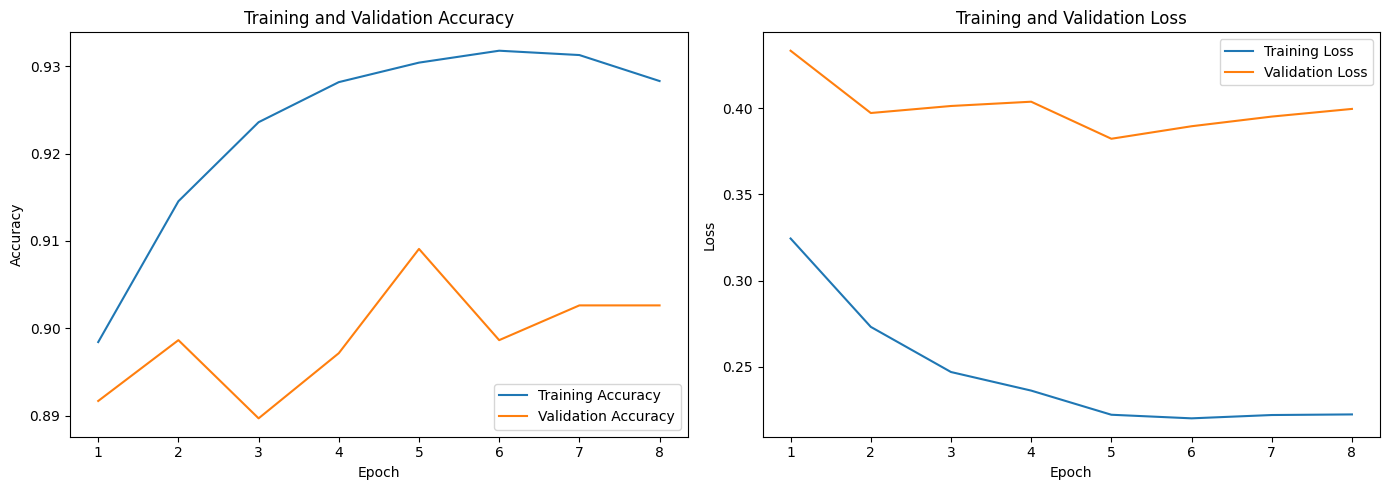

In [24]:
import matplotlib.pyplot as plt

# Ekstrak data dari objek history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

epochs_range = range(1, len(training_loss) + 1)

# Print metrics
print(f"Final Training Accuracy: {training_accuracy[-1]:.4f}")
print(f"Final Validation Accuracy: {validation_accuracy[-1]:.4f}")
print(f"Final Training Loss: {training_loss[-1]:.4f}")
print(f"Final Validation Loss: {validation_loss[-1]:.4f}")

# Plot training & validation accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

In [18]:
new_model = tf.keras.models.load_model('models/resnet50/')

In [19]:
new_model.evaluate(train_ds)
print("Train accuracy: ", new_model.evaluate(train_ds)[1])

253/253 [==============================] - 328s 1s/step - loss: 0.1784 - accuracy: 0.9451
Train accuracy:  0.9451325535774231


In [20]:
new_model.evaluate(val_ds)
print("Validation accuracy: ", new_model.evaluate(val_ds)[1])

63/63 [==============================] - 93s 1s/step - loss: 0.3917 - accuracy: 0.9071
Validation accuracy:  0.9071038365364075


In [21]:
new_model.evaluate(test_ds)
print("Test accuracy: ", new_model.evaluate(test_ds)[1])

119/119 [==============================] - 167s 1s/step - loss: 0.2466 - accuracy: 0.9291
Test accuracy:  0.9290611743927002


In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Generate predictions on the test set
predictions = model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels
true_labels = test_ds.classes

# Print the classification report
print(classification_report(true_labels, predicted_labels))

# Print the confusion matrix
print(confusion_matrix(true_labels, predicted_labels))

119/119 [==============================] - 175s 1s/step
              precision    recall  f1-score   support

           0       0.10      0.10      0.10       308
           1       0.09      0.09      0.09       347
           2       0.07      0.07      0.07       285
           3       0.05      0.05      0.05       229
           4       0.12      0.12      0.12       375
           5       0.10      0.10      0.10       318
           6       0.07      0.07      0.07       284
           7       0.09      0.08      0.08       312
           8       0.11      0.11      0.11       359
           9       0.10      0.10      0.10       345
          10       0.07      0.07      0.07       323
          11       0.09      0.09      0.09       307

    accuracy                           0.09      3792
   macro avg       0.09      0.09      0.09      3792
weighted avg       0.09      0.09      0.09      3792

[[31 21 25 13 22 17 24 23 28 41 31 32]
 [29 30 24 19 38 28 29 30 32 35 29 24]

### Save the model

In [25]:
model.save('resnet50FindtoFine.h5')
print('resnet50FindtoFine.h5')

c:\Users\pozak\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


resnet50FindtoFine.h5
